In [26]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import RocCurveDisplay


In [27]:
def get_metrics(y_true, y_pred, labels=None):
    """ Compute various measures from a confusion matrix

    Args:
        y_true: a column of the true labels.
        y_pred: a column of the predicted labels.
    Returns:
        A dictionary of metrics.
    """
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = conf_mat.ravel()

    return {
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'balanced_accuracy': 0.5 * tn / (tn + fp) + 0.5 * tp / (tp + fn),
        'specificity': tn / (tn + fp),
        'sensitivity': tp / (tp + fn),
        'ppv': tp / (tp + fp),
        'npv': tn / (tn + fn)
    }

def get_class_prob_df(clf, X):
    """ Return a dataframe of class probabilities.

    Arg:
        clf: A fitted model object
        X: The matrix of (test) features.
    Returns: A dataframe of class probabilities
    """
    return pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)


In [28]:
# Load the Gold Glove dataset
gold_glove = pl.read_csv('./data/gold_glove.csv')
gold_glove.head()

# Display unique values for gold_glove and relevant columns
print(gold_glove['gold_glove'].unique().to_list())
print(gold_glove['POS'].unique().to_list())
print(gold_glove['lgID'].unique().to_list())


['NO', 'Yes']
['2B', '3B', 'OF', '1B', 'SS', 'C', 'P']
['AL', 'NL']


In [29]:
gold_glove = (gold_glove
             .with_columns(
                 lgID_numeric=pl.when(pl.col('lgID') == 'NL').then(0)
                 .when(pl.col('lgID') == 'AL').then(1),
                 POS_numeric=pl.when(pl.col('POS') == 'P').then(0)
                 .when(pl.col('POS') == 'C').then(1)
                 .when(pl.col('POS') == '1B').then(2)
                 .when(pl.col('POS') == '2B').then(3)
                 .when(pl.col('POS') == '3B').then(4)
                 .when(pl.col('POS') == 'SS').then(5)
                 .when(pl.col('POS') == 'OF').then(6)
             )
)

gold_glove.head()


playerID,yearID,lgID,POS,awardID,gold_glove,Training_Validation,lgID_numeric,POS_numeric
str,i64,str,str,str,str,str,i32,i32
"""aardsda01""",2013,"""NL""","""P""",null,"""NO""","""Training""",0,0
"""aardsda01""",2015,"""NL""","""P""",null,"""NO""","""Training""",0,0
"""abadfe01""",2013,"""NL""","""P""",null,"""NO""","""Training""",0,0
"""abadfe01""",2014,"""AL""","""P""",null,"""NO""","""Training""",1,0
"""abadfe01""",2015,"""AL""","""P""",null,"""NO""","""Training""",1,0


In [30]:
X_train_gold_glove = (gold_glove
                      .filter(pl.col('Training_Validation') == 'Training')
                      .drop(['playerID', 'gold_glove', 'awardID', 'Training_Validation', 'POS', 'lgID'])
                      )
X_train_gold_glove = X_train_gold_glove.to_pandas()

Y_train_gold_glove = (gold_glove
                      .filter(pl.col('Training_Validation') == 'Training')
                      .select(pl.col('gold_glove'))
                      )
Y_train_gold_glove = Y_train_gold_glove.to_pandas()


In [31]:
dtc_param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [1, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, "balanced"]
}

state = 458
cv_obj_dtc = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

dtc_grid_search = GridSearchCV(DecisionTreeClassifier(), dtc_param_grid, verbose=3, cv=cv_obj_dtc)
dtc_grid_search.fit(X_train_gold_glove, Y_train_gold_glove)

best_dtc_model = dtc_grid_search.best_estimator_
print("Best Decision Tree params:", dtc_grid_search.best_params_)


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 2/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 3/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 4/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 5/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 6/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 7/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 8/10] END class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=1;, scor

C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py

In [32]:
X_test_gold_glove = (gold_glove
                     .filter(pl.col('Training_Validation') == 'Validation')
                     .drop(['playerID', 'gold_glove', 'awardID', 'Training_Validation', 'POS', 'lgID'])
                     )
X_test_gold_glove = X_test_gold_glove.to_pandas()

Y_test_gold_glove = (gold_glove
                     .filter(pl.col('Training_Validation') == 'Validation')
                     .select(pl.col('gold_glove'))
                     )
Y_test_gold_glove = Y_test_gold_glove.to_pandas()


In [33]:
dtc_y_test_pred = dtc_grid_search.predict(X_test_gold_glove)
metrics = get_metrics(Y_test_gold_glove, dtc_y_test_pred)
print("Metrics for Decision Tree Classifier:", metrics)


Metrics for Decision Tree Classifier: {'accuracy': np.float64(0.9915966386554622), 'balanced_accuracy': np.float64(0.5), 'specificity': np.float64(1.0), 'sensitivity': np.float64(0.0), 'ppv': np.float64(nan), 'npv': np.float64(0.9915966386554622)}


C:\Users\at3571rj\AppData\Local\Temp\ipykernel_13416\768677893.py:18: RuntimeWarning: invalid value encountered in scalar divide
  'ppv': tp / (tp + fp),


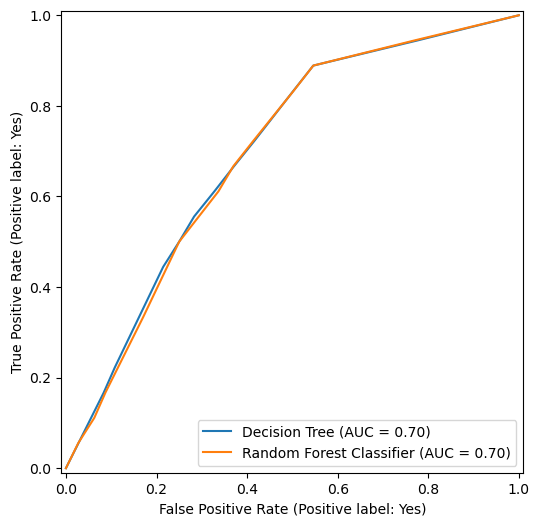

In [35]:
from sklearn.metrics import RocCurveDisplay

plt.rcParams["figure.figsize"] = (8, 6)
ax = plt.gca()

# Plot each ROC curve
RocCurveDisplay.from_estimator(best_dtc_model, X_test_gold_glove, Y_test_gold_glove, ax=ax, name="Decision Tree")
RocCurveDisplay.from_estimator(best_rfc_model, X_test_gold_glove, Y_test_gold_glove, ax=ax, name="Random Forest Classifier")

plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

# Get class probabilities for AUC calculation
dtc_y_test_prob = best_dtc_model.predict_proba(X_test_gold_glove)[:, 1]
rfc_y_test_prob = best_rfc_model.predict_proba(X_test_gold_glove)[:, 1]

dtc_auc = roc_auc_score(Y_test_gold_glove, dtc_y_test_prob)
rfc_auc = roc_auc_score(Y_test_gold_glove, rfc_y_test_prob)

dtc_auc, rfc_auc


(np.float64(0.6997672107135383), np.float64(0.6963799958150241))

In [37]:
dtc_y_test_prob = get_class_prob_df(best_dtc_model, X_test_gold_glove)
rfc_y_test_prob = get_class_prob_df(best_rfc_model, X_test_gold_glove)

from sklearn.metrics import roc_auc_score

dtc_auc = roc_auc_score(Y_test_gold_glove, dtc_y_test_prob['Yes'])
rfc_auc = roc_auc_score(Y_test_gold_glove, rfc_y_test_prob['Yes'])

print("AUC for Decision Tree:", dtc_auc)
print("AUC for Random Forest:", rfc_auc)


AUC for Decision Tree: 0.6997672107135383
AUC for Random Forest: 0.6963799958150241


# Regression

In [74]:
# Load Salaries dataset
salaries = pl.read_csv('./data/salaries_df.csv')
print(salaries.head())


shape: (5, 61)
┌───────────┬────────┬──────────┬───────┬───┬─────────────┬─────────────┬───────────────┬─────────────────────┐
│ playerID  ┆ yearID ┆ salary   ┆ stint ┆ … ┆ SH_pitching ┆ SF_pitching ┆ GIDP_pitching ┆ Training_Validation │
│ ---       ┆ ---    ┆ ---      ┆ ---   ┆   ┆ ---         ┆ ---         ┆ ---           ┆ ---                 │
│ str       ┆ i64    ┆ f64      ┆ i64   ┆   ┆ i64         ┆ i64         ┆ i64           ┆ str                 │
╞═══════════╪════════╪══════════╪═══════╪═══╪═════════════╪═════════════╪═══════════════╪═════════════════════╡
│ stewach01 ┆ 2012   ┆ 482500.0 ┆ 1     ┆ … ┆ null        ┆ null        ┆ null          ┆ Training            │
│ villaca01 ┆ 2012   ┆ 2.2775e6 ┆ 1     ┆ … ┆ 2           ┆ 4           ┆ 12            ┆ Training            │
│ beimejo01 ┆ 2007   ┆ 912500.0 ┆ 1     ┆ … ┆ 5           ┆ 2           ┆ 11            ┆ Training            │
│ dukesel01 ┆ 2007   ┆ 380000.0 ┆ 1     ┆ … ┆ null        ┆ null        ┆ null          ┆

In [75]:
# Prepare training features and labels
X_train_salaries = (salaries
                    .filter(pl.col('Training_Validation') == 'Training')
                    .drop(['salary', 'Training_Validation', 'playerID']))

Y_train_salaries = (salaries
                    .filter(pl.col('Training_Validation') == 'Training')
                    .select(['salary']))

X_train_salaries = X_train_salaries.to_pandas()
Y_train_salaries = Y_train_salaries.to_pandas()


In [77]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Assuming X_train_salaries and Y_train_salaries are defined

# Check and encode categorical features if necessary
# Encode categorical variables using one-hot encoding
X_train_salaries_encoded = pd.get_dummies(X_train_salaries, drop_first=True)

# Set up parameter grid for Decision Tree Regressor
dtr_param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],  # Changed to start from 2
    'min_samples_leaf': [1, 5, 10]
}

# Set up cross-validation
state = 88393
my_cv_dtr = KFold(n_splits=10, shuffle=True, random_state=state)

# Grid search for the best Decision Tree model
dtr_grid_search = GridSearchCV(DecisionTreeRegressor(), dtr_param_grid, verbose=3, cv=my_cv_dtr)

# Fit the model with encoded features
dtr_grid_search.fit(X_train_salaries_encoded, Y_train_salaries)

# Best score and parameters
print("Best Score:", dtr_grid_search.best_score_)
print("Best Parameters:", dtr_grid_search.best_params_)
best_dtr_model = dtr_grid_search.best_estimator_


Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-0.073 total time=   4.4s
[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-0.027 total time=   3.2s
[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.061 total time=   3.7s
[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.022 total time=   3.3s
[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-0.170 total time=   3.7s
[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-0.065 total time=   3.6s
[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-0.044 total time=   3.1s
[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=-0.110 total time=   2.8s
[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.108 total time=   3.7s
[CV 

In [82]:
X_test_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Validation')
                   .drop(['salary', 'Training_Validation', 'playerID'])
                   )
X_test_salaries = X_test_salaries.to_pandas()

Y_test_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Validation')
                   .select(['salary'])
                   )
Y_test_salaries = Y_test_salaries.to_pandas()


In [83]:
# Predict using the best Decision Tree Regressor model
dtr_y_test_pred = dtr_grid_search.predict(X_test_salaries)

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

regression_metrics_dtr = {
    'R^2': explained_variance_score(Y_test_salaries, dtr_y_test_pred),
    'MAE': mean_absolute_error(Y_test_salaries, dtr_y_test_pred),
    'MSE': mean_squared_error(Y_test_salaries, dtr_y_test_pred),
    'RMSE': mean_squared_error(Y_test_salaries, dtr_y_test_pred, squared=False)
}

print("Decision Tree Regressor Metrics:", regression_metrics_dtr)


Decision Tree Regressor Metrics: {'R^2': 0.1807564077291136, 'MAE': np.float64(3527733.1176698613), 'MSE': np.float64(29398180663687.195), 'RMSE': np.float64(5422008.914017681)}


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Load Salaries dataset
salaries = pl.read_csv('./data/salaries_df.csv')
print(salaries.head())

# Prepare training features and labels
X_train_salaries = (salaries
                    .filter(pl.col('Training_Validation') == 'Training')
                    .drop(['salary', 'Training_Validation', 'playerID']))

Y_train_salaries = (salaries
                    .filter(pl.col('Training_Validation') == 'Training')
                    .select(['salary']))

X_train_salaries = X_train_salaries.to_pandas()
Y_train_salaries = Y_train_salaries.to_pandas()

# Check and encode categorical features if necessary
X_train_salaries_encoded = pd.get_dummies(X_train_salaries, drop_first=True)

# Prepare test features and labels
X_test_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Validation')
                   .drop(['salary', 'Training_Validation', 'playerID'])
                   )
X_test_salaries = X_test_salaries.to_pandas()

Y_test_salaries = (salaries
                   .filter(pl.col('Training_Validation') == 'Validation')
                   .select(['salary'])
                   )
Y_test_salaries = Y_test_salaries.to_pandas()

# Encode the test set using the same method as the training set
X_test_salaries_encoded = pd.get_dummies(X_test_salaries, drop_first=True)

# Align the train and test sets to ensure they have the same columns
X_train_salaries_encoded, X_test_salaries_encoded = X_train_salaries_encoded.align(X_test_salaries_encoded, join='left', axis=1, fill_value=0)

# Set up parameter grid for Decision Tree Regressor
dtr_param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Set up cross-validation
state = 88393
my_cv_dtr = KFold(n_splits=10, shuffle=True, random_state=state)

# Grid search for the best Decision Tree model
dtr_grid_search = GridSearchCV(DecisionTreeRegressor(), dtr_param_grid, verbose=3, cv=my_cv_dtr)

# Fit the model with encoded features
dtr_grid_search.fit(X_train_salaries_encoded, Y_train_salaries)

# Best score and parameters for Decision Tree
print("Best Score (Decision Tree):", dtr_grid_search.best_score_)
print("Best Parameters (Decision Tree):", dtr_grid_search.best_params_)
best_dtr_model = dtr_grid_search.best_estimator_

# Predict using the best Decision Tree Regressor model
dtr_y_test_pred = dtr_grid_search.predict(X_test_salaries_encoded)

# Regression metrics for Decision Tree
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

regression_metrics_dtr = {
    'R^2': explained_variance_score(Y_test_salaries, dtr_y_test_pred),
    'MAE': mean_absolute_error(Y_test_salaries, dtr_y_test_pred),
    'MSE': mean_squared_error(Y_test_salaries, dtr_y_test_pred),
    'RMSE': mean_squared_error(Y_test_salaries, dtr_y_test_pred, squared=False)
}

print("Decision Tree Regressor Metrics:", regression_metrics_dtr)

# ---------------- Random Forest Regressor ----------------
from sklearn.ensemble import RandomForestRegressor

# Set up parameter grid for Random Forest Regressor
rfr_param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search for the best Random Forest model
rfr_grid_search = GridSearchCV(RandomForestRegressor(), rfr_param_grid, verbose=3, cv=my_cv_dtr)

# Fit the model with encoded features
rfr_grid_search.fit(X_train_salaries_encoded, Y_train_salaries)

# Best score and parameters for Random Forest
print("Best Score (Random Forest):", rfr_grid_search.best_score_)
print("Best Parameters (Random Forest):", rfr_grid_search.best_params_)
best_rfr_model = rfr_grid_search.best_estimator_

# Predict using the best Random Forest model
rfr_y_test_pred = rfr_grid_search.predict(X_test_salaries_encoded)

# Regression metrics for Random Forest
regression_metrics_rfr = {
    'R^2': explained_variance_score(Y_test_salaries, rfr_y_test_pred),
    'MAE': mean_absolute_error(Y_test_salaries, rfr_y_test_pred),
    'MSE': mean_squared_error(Y_test_salaries, rfr_y_test_pred),
    'RMSE': mean_squared_error(Y_test_salaries, rfr_y_test_pred, squared=False)
}

print("Random Forest Regressor Metrics:", regression_metrics_rfr)


shape: (5, 61)
┌───────────┬────────┬──────────┬───────┬───┬─────────────┬─────────────┬───────────────┬─────────────────────┐
│ playerID  ┆ yearID ┆ salary   ┆ stint ┆ … ┆ SH_pitching ┆ SF_pitching ┆ GIDP_pitching ┆ Training_Validation │
│ ---       ┆ ---    ┆ ---      ┆ ---   ┆   ┆ ---         ┆ ---         ┆ ---           ┆ ---                 │
│ str       ┆ i64    ┆ f64      ┆ i64   ┆   ┆ i64         ┆ i64         ┆ i64           ┆ str                 │
╞═══════════╪════════╪══════════╪═══════╪═══╪═════════════╪═════════════╪═══════════════╪═════════════════════╡
│ stewach01 ┆ 2012   ┆ 482500.0 ┆ 1     ┆ … ┆ null        ┆ null        ┆ null          ┆ Training            │
│ villaca01 ┆ 2012   ┆ 2.2775e6 ┆ 1     ┆ … ┆ 2           ┆ 4           ┆ 12            ┆ Training            │
│ beimejo01 ┆ 2007   ┆ 912500.0 ┆ 1     ┆ … ┆ 5           ┆ 2           ┆ 11            ┆ Training            │
│ dukesel01 ┆ 2007   ┆ 380000.0 ┆ 1     ┆ … ┆ null        ┆ null        ┆ null          ┆

C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.277 total time=  16.1s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.428 total time=  15.5s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.322 total time=  17.5s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.394 total time=  15.2s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.348 total time=  16.1s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.282 total time=  17.6s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.331 total time=  15.3s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.330 total time=  15.3s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.449 total time=  16.8s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.356 total time=  20.7s


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.372 total time= 1.5min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.454 total time= 1.6min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.374 total time= 1.7min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.428 total time= 1.8min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.395 total time= 1.8min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.323 total time= 1.7min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.393 total time= 1.9min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.386 total time= 2.0min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.478 total time= 1.6min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.441 total time= 1.7min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.363 total time= 2.9min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.455 total time= 3.3min


C:\Users\at3571rj\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
